# Reinforcement Learning Overview

This notebook implements value iteration and policy iteration.

## 1. Import libraries

In [1]:
import numpy as np
import gymnasium as gym
import gymnasium.spaces as spaces
import time
import torch
import matplotlib.pyplot as plt

In [2]:
# action mapping for display the final result
action_mapping = {
    3: '\u2191', # UP
    2: '\u2192', # RIGHT
    1: '\u2193', # DOWN
    0: '\u2190' # LEFT
}
print(' '.join([action_mapping[i] for i in range(4)]))

← ↓ → ↑


## 2. Setup GYM Env for playing & Helper functions

We define a function that will take a GYM environment and plays number of games according to given policy.

In [3]:
def play_episodes(environment, n_episodes, policy, random = False, categorial = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        environment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the environment every time when playing a new episode
        state = environment.reset()[0]

        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = environment.action_space.sample()
            else:
                if categorial:
                    action = np.random.choice(len(policy[state]), p=policy[state])
                else:
                    action = policy[state] 

            # take the next step
            next_state, reward,  terminated, info = environment.step(action)[:-1]
            
            environment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 1.0:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward
            

In [52]:
def one_step_lookahead_categorial(env, state, Q , policy, discount_factor = 0.99):
    """
    Helper function to  calculate state-value function
    
    Arguments:
        env: openAI GYM environment object
        state: state to consider
        Q: Estimated Value for each state-action pair. Table of shape N x A
        discount_factor: MDP discount factor
        
    Return:
        action_values: Expected value of each action in a state. Vector of length nA
    """
    
    # initialize vector of action values
    action_values = np.zeros(env.action_space.n) 
    # loop over the actions we can take in an environment 
    for action in range(env.action_space.n):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * policy[next_state] @ Q[next_state]))
            
    return action_values

In [43]:
def update_policy_categorial(env, policy, Q, discount_factor, temperature, improvement_operator = "argmax"):
    
    """
    Helper function to update a given policy based on given value function.
    
    Arguments:
        env: openAI GYM environment object.
        policy: categorial policy to update.
        Q: Estimated Value for each state-action pair. Table of shape N x S.
        discount_factor: MDP discount factor.
    Return:
        policy: Updated policy based on the given state-action value function 'Q'.
    """
    if improvement_operator == "None":
        return policy
    
    for state in range(env.observation_space.n):
        # for a given state compute state-action value.
        action_values = one_step_lookahead_categorial(env, state, Q, policy, discount_factor)
        # choose the action which maximizez the state-action value.
        if improvement_operator == "argmax":
            best_action = np.argmax(action_values)
            one_hot_policy = np.zeros(env.action_space.n)
            one_hot_policy[best_action] = 1
            policy[state] = one_hot_policy
        elif improvement_operator == "policy-regularized_softmax":
            policy[state] = policy_regularized_softmax(policy[state], temperature, action_values)
        
    return policy
    

In [44]:
def policy_regularized_softmax(policy, temperature, Q_value):
    """
    Helper function for the policy-regularized softmax function.

    Arguments:
        policy: current evaluated policy
        temperature: temperature hyperparameter 
        Q_value: current Q value function
    Return:
        action_dist: Improved action probability distribution for the new policy.
    """
    # convert to torch tensor
    policy = torch.from_numpy(policy)
    Q_value = torch.from_numpy(Q_value)
    action_dist = torch.nn.functional.softmax(torch.log(policy) + temperature * Q_value, dim = 0)
    return action_dist 

In [31]:
def get_initial_state_value(Q, policy):
    """
    Calculate the initial state value V(s_0) based on
    E_{a~\pi(s0)} Q(s0, \pi(s0))
    """
    V_init = 0
    for i, action_prob in enumerate(policy[0]): # calculate V value in initial state
        V_init += action_prob*Q[0][i]
    return V_init

## 3. Solve for Value Iteration.

![](nb_images/value_iter.png)

In [8]:
def value_iteration(env, improvement_operator = "argmax", value_improvement_operator = "argmax", discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM environment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        V: Optimal state-Value function. Vector of lenth nS.
        optimal_policy: Optimal policy. Vector of length nS.
    
    """
    # intialize value fucntion
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    Q_copied = np.zeros((env.observation_space.n,env.action_space.n)) # TODO: double improvement
    # intialize a random implicit categorial policy
    random_actions = np.random.randint(0, 1000, (env.observation_space.n, env.action_space.n))
    policy = random_actions/random_actions.sum(axis = 1, keepdims = True)

    policy_prev = np.copy(policy)
    temperature = 1.0    

    # TODO: make categorical, check how to resuse policy iteration functions
    # iterate over max_iterations
    for i in range(max_iteration):
        
        #  keep track of change with previous value function
        prev_Q = np.copy(Q) 
    
        # loop over all states
        for state in range(env.observation_space.n):
            # copied_policy = np.copy(policy) 
            # improve copied policy with second improvement operator
            # copied_policy = update_policy_categorial(env, copied_policy, Q_copied, discount_factor, temperature, improvement_operator=value_improvement_operator)
            # Asynchronously update the state-action value
            #action_values = one_step_lookahead(env, state, V, discount_factor)
            # Synchronously update the state-action value
            # TODO: change this to policy improvement step, value update step with new policy, repeat.
            policy = update_policy_categorial(env, policy, Q, discount_factor, temperature, improvement_operator=improvement_operator)
            # action_values = one_step_lookahead(env, state, prev_v, discount_factor)  
            action_values = one_step_lookahead_categorial(env, state, Q , discount_factor)
            # for action, action_prob in enumerate(policy[state]): # evaluate policy value over all actions
            #     for probablity, next_state, reward, info in env.P[state][action]:
            #         Q[state][action] += probablity * (reward + (discount_factor * np.max(Q[next_state])))
                    
            # select best action to perform based on highest state-action value
            # best_action_value = np.max(action_values)
            
            # update the current state-value fucntion
            Q[state] = action_values
            
        # # if policy not changed over 10 iterations it converged.
        # if i % 10 == 0:
        #     # if values of 'V' not changing after one iteration
        #     if (np.all(np.isclose(policy, prev_v))):
        #         print('Value converged at iteration %d' %(i+1))
        #         break

        if i % 10 == 0:
                if (np.all(np.equal(policy, policy_prev))):
                    print('policy converged at iteration %d' %(i+1))
                    break
                policy_prev = np.copy(policy)
    # intialize optimal policy
    # optimal_policy = np.zeros(env.observation_space.n, dtype = 'int8')
    
    # update the optimal polciy according to optimal value function 'V'
    # optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return Q, policy

## Test the Algorithim

In [45]:
environment = gym.make('FrozenLake-v1', is_slippery = False)#, render_mode = "human")
tic = time.time()
opt_Q, opt_Policy = value_iteration(environment.env, max_iteration = 1000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ')
print(opt_V.reshape((environment.observation_space.n, environment.action_space.n)))
print(opt_Policy)
print("Most likely actions taken by policy: ")
arrow_visualization_VI = np.array([action_mapping[(np.argmax(action))] for action in opt_Policy])
arrow_visualization_VI = arrow_visualization_VI.reshape((4,4))
print(arrow_visualization_VI)

ValueError: setting an array element with a sequence.

In [125]:
n_episode = 10
wins, total_reward, avg_reward = play_episodes(environment, n_episode, opt_Policy, random = False, categorial = True)
# wins, total_reward, avg_reward = play_episodes(environment2, n_episode, opt_policy2, random = False, categorial = True)

In [126]:
print(f'Total wins with value iteration: {wins}')
print(f"Average rewards with value iteration: {avg_reward}")

Total wins with value iteration: 10
Average rewards with value iteration: 1.0


## 4. Solve for Policy Iteration

# Helper functions

In [55]:
def policy_eval(env, policy, Q, discount_factor): # actually just one step in the evaluation
    """
    Helper function to evaluate a policy.
    
    Arguments:
        env: openAI GYM environment object.
        policy: policy to evaluate.
        Q: Estimated Value for each state-action pair. Table of shape N x A
        discount_factor: MDP discount factor.
    Return:
        policy_value: Estimated value of each state-action pair following a given policy and state-action value 'Q'. 
        
    """
    policy_value = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(env.observation_space.n):
        for action, action_prob in enumerate(policy[state]): # evaluate policy value over all actions
            for probablity, next_state, reward, info in env.P[state][action]:
                policy_value[state][action] += probablity * (reward + (discount_factor * policy[next_state] @ Q[next_state]))
    
    return policy_value

# Update policy functions

# Main loop

In [192]:
def policy_iteration(env, improvement_operator = "argmax", value_improvement_operator = "argmax", discount_factor = 0.999, max_iteration = 1000):
    """
    Algorithm to solve MPD.
    
    Arguments:
        env: openAI GYM environment object.
        discount_factor: MDP discount factor.
        max_iteration: Maximum No.  of iterations to run.
        
    Return:
        Q: Optimal state-action value function. Table of N x A
        new_policy: Optimal policy. Table of N x A
    
    """
    # intialize the state-Value function
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    Q_copied = np.zeros((env.observation_space.n,env.action_space.n))
    # intialize a random implicit categorial policy
    random_actions = np.random.randint(0, 1000, (env.observation_space.n, env.action_space.n))
    policy = random_actions/random_actions.sum(axis = 1, keepdims = True)

    policy_prev = np.copy(policy)
    Q_prev = np.copy(Q)
    Q_copied_prev = np.copy(Q_copied)
    temperature = 1.0
    max_it_eval = 1
    V_init_states = []
    V_init = get_initial_state_value(Q, policy)
    V_init_states.append(V_init)
    
    for i in range(max_iteration):
        # copy the policy
        copied_policy = np.copy(policy)
        # improve copied policy with second improvement operator
        copied_policy = update_policy_categorial(env, copied_policy, Q_copied, discount_factor, temperature, improvement_operator=value_improvement_operator)
        # Evaluate copied policy 
        for j in range(max_it_eval):
            Q = policy_eval(env, policy, Q, discount_factor)
            # if i % 10 == 0:
            #     if (np.all(np.isclose(Q, Q_prev))):
            #         print('Policy evaluation converged at iteration %d' %(j+1))
            #         break
            #     Q_prev = np.copy(Q)

        for k in range(max_it_eval):
            Q_copied = policy_eval(env, copied_policy, Q_copied, discount_factor) 
            # if i % 10 == 0:
            #     if (np.all(np.isclose(Q_copied, Q_copied_prev))):
            #         print('Copy policy evaluation converged at iteration %d' %(k+1))
            #         break
            #     Q_copied_prev = np.copy(Q_copied)

        
        # improve the main policy with Q_copied
        policy = update_policy_categorial(env, policy, Q_copied, discount_factor, temperature, improvement_operator=improvement_operator)

        # save V values for initial state        
        V_inital_state = get_initial_state_value(Q, policy)
        V_init_states.append(V_inital_state)
        # if Q table has not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.isclose(Q, Q_prev))):
                print('Q table converged at iteration %d' %(i+1))
                break
            Q_prev = np.copy(Q)
        # if i % 10 == 0:
        #     if (np.all(np.isclose(policy, policy_prev))):
        #         print('policy converged at iteration %d' %(i+1))
        #         break
        #     policy_prev = np.copy(policy)
        
    return Q, policy, V_init_states

## Test Policy Iteration

In [194]:
environment2 = gym.make('FrozenLake-v1', is_slippery = False) #, render_mode = "human")
tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_V2, opt_policy2, V_init_states2 = policy_iteration(environment2.env, improvement_operator="argmax", value_improvement_operator = "None", discount_factor = 0.9999, max_iteration = 1000)
toc = time.time()
elapsed_time = (toc - tic) * 1000
print (f"Time to converge: {elapsed_time: 0.3} ms")
print('Optimal Value function: ')
print(opt_V2.reshape((environment2.observation_space.n, environment2.action_space.n)))
print('Final Policy: ')
print(np.round(opt_policy2,2))
# Display the most likely policy in discrete action
print("Most likely actions taken by policy: ")
arrow_visualization = np.array([action_mapping[(np.argmax(action))] for action in opt_policy2])
arrow_visualization = arrow_visualization.reshape((4,4))
print(arrow_visualization)
# print(' '.join(arrow_visualization))

Q table converged at iteration 21
Time to converge:  45.1 ms
Optimal Value function: 
[[0.99940015 0.9995001  0.9995001  0.99940015]
 [0.99940015 0.         0.99960006 0.9995001 ]
 [0.9995001  0.99970003 0.9995001  0.99960006]
 [0.99960006 0.         0.9995001  0.9995001 ]
 [0.9995001  0.99960006 0.         0.99940015]
 [0.         0.         0.         0.        ]
 [0.         0.99980001 0.         0.99960006]
 [0.         0.         0.         0.        ]
 [0.99960006 0.         0.99970003 0.9995001 ]
 [0.99960006 0.99980001 0.99980001 0.        ]
 [0.99970003 0.9999     0.         0.99970003]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.99980001 0.9999     0.99970003]
 [0.99980001 0.9999     1.         0.99980001]
 [0.         0.         0.         0.        ]]
Final Policy: 
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 

In [195]:
n_episode = 10
wins, total_reward, avg_reward = play_episodes(environment2, n_episode, opt_policy2, random = False, categorial = True)

In [196]:
print(f'Total wins with Policy iteration: {wins}')
print(f"Average rewards with Policy iteration: {avg_reward}")

Total wins with Policy iteration: 10
Average rewards with Policy iteration: 1.0


## Comparison between methods

In [197]:
environment_comparison = gym.make('FrozenLake-v1') #, render_mode = "human")

discount_fac = 0.9999999999

tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_Q_argmax_none, opt_policy_argmax_none, initial_policy_values_argmax_none = policy_iteration(environment_comparison.env, improvement_operator="argmax", value_improvement_operator = "None", discount_factor = discount_fac, max_iteration = 1000)
toc = time.time()
argmax_none_elapsed_time = (toc - tic) * 1000
print(f"Time to converge argmax-none: {argmax_none_elapsed_time: 0.3} ms")

tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_Q_softmax_argmax, opt_policy_softmax_argmax, initial_policy_values_softmax_argmax = policy_iteration(environment_comparison.env, improvement_operator="policy-regularized_softmax", value_improvement_operator = "argmax", discount_factor = discount_fac, max_iteration = 1000)
toc = time.time()
softmax_argmax_elapsed_time = (toc - tic) * 1000
print(f"Time to converge softmax-argmax: {softmax_argmax_elapsed_time: 0.3} ms")

tic = time.time()
# options for improvement operator: "argmax", "policy-regularized_softmax" or "None"
opt_Q_softmax_softmax, opt_policy_softmax_softmax, initial_policy_values_softmax_softmax = policy_iteration(environment_comparison.env, improvement_operator="policy-regularized_softmax", value_improvement_operator = "policy-regularized_softmax", discount_factor = discount_fac, max_iteration = 1000)
toc = time.time()
softmax_softmax_elapsed_time = (toc - tic) * 1000
print(f"Time to converge softmax-softmax: {softmax_softmax_elapsed_time: 0.3} ms")


Q table converged at iteration 451
Time to converge argmax-none:  1.17e+03 ms
Q table converged at iteration 571
Time to converge softmax-argmax:  2.23e+03 ms
Q table converged at iteration 651
Time to converge softmax-softmax:  2.99e+03 ms


In [198]:
# opt_Q_softmax_softmax

In [199]:
# print(np.round(opt_policy_softmax_argmax,3))

In [200]:
comparison_episodes = 100
policies = [opt_policy_argmax_none, opt_policy_softmax_argmax, opt_policy_softmax_softmax]
elapsed_times = [argmax_none_elapsed_time, softmax_argmax_elapsed_time, softmax_softmax_elapsed_time]

wins_per_policy = []
total_rewards_per_policy = []
avg_rewards_per_policy = []

for policy in policies:
    n_wins, total_reward, avg_reward = play_episodes(environment_comparison, comparison_episodes, policy, random = False, categorial = True)
    wins_per_policy.append(n_wins)
    total_rewards_per_policy.append(total_reward)
    avg_rewards_per_policy.append(avg_reward)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


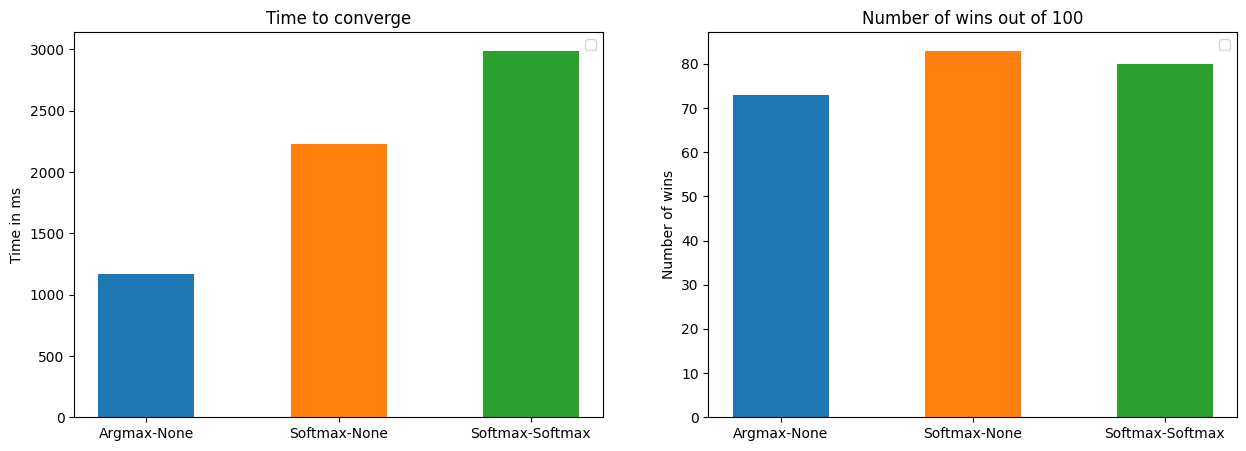

In [201]:
x = np.arange(len(elapsed_times))
width = 0.5  # Width of the bars

# Creating the bar plot
fig, ax = plt.subplots(1,2, figsize=(15, 5))
bar = ax[0].bar("Argmax-None", elapsed_times[0], width)
bar = ax[0].bar("Softmax-None", elapsed_times[1], width)
bar = ax[0].bar("Softmax-Softmax", elapsed_times[2], width)

# Adding labels, title, and ticksax.set_xlabel('Elapsed Time')
ax[0].set_ylabel('Time in ms')
ax[0].set_title('Time to converge')
ax[0].set_xticks(x)
ax[0].legend()

bar = ax[1].bar("Argmax-None", wins_per_policy[0], width)
bar = ax[1].bar("Softmax-None", wins_per_policy[1], width)
bar = ax[1].bar("Softmax-Softmax", wins_per_policy[2], width)

ax[1].set_ylabel('Number of wins')
ax[1].set_title('Number of wins out of 100')
ax[1].set_xticks(x)
ax[1].legend()
# Showing the plot
plt.show()

### Plot policy intial value

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


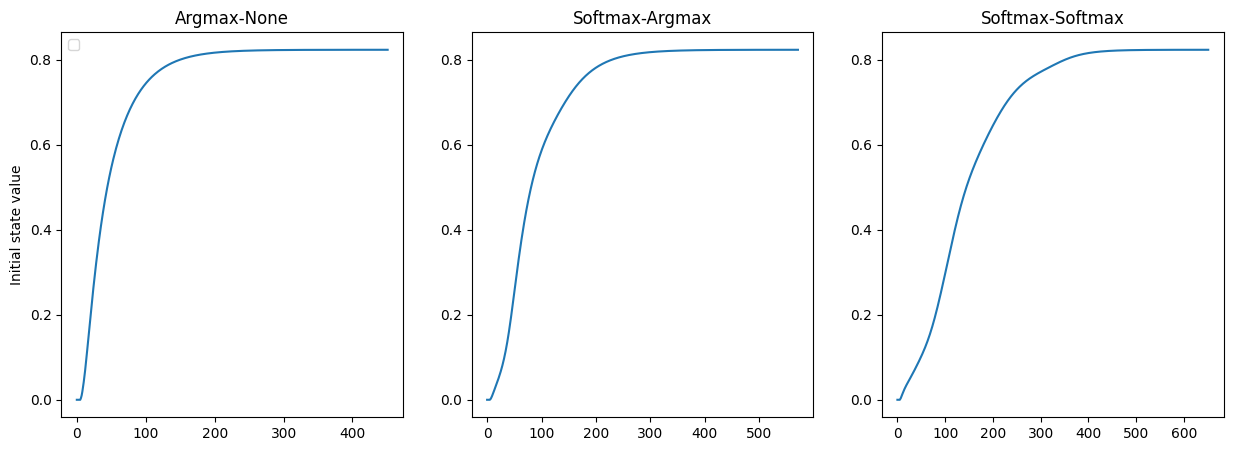

In [202]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].plot(np.array(initial_policy_values_argmax_none))
ax[1].plot(np.array(initial_policy_values_softmax_argmax))
ax[2].plot(np.array(initial_policy_values_softmax_softmax))

ax[0].set_ylabel('Initial state value')
ax[0].set_title('Argmax-None')
ax[1].set_title('Softmax-Argmax')
ax[2].set_title('Softmax-Softmax')

ax[0].legend()
plt.show()

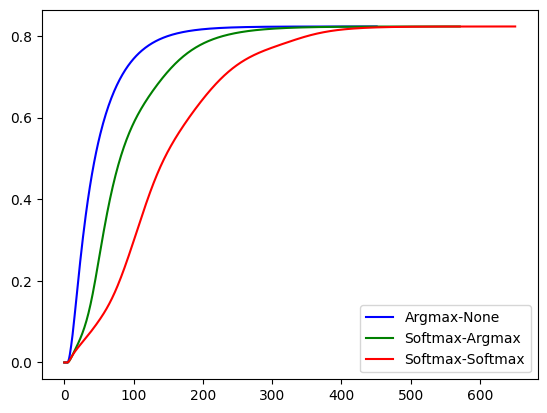

In [203]:
# initial_policy_values_argmax_none_padded = np.pad(initial_policy_values_argmax_none, (0,1001-len(initial_policy_values_argmax_none)), "edge")
plt.plot(np.array(initial_policy_values_argmax_none), c = "b", label = "Argmax-None")
plt.plot(np.array(initial_policy_values_softmax_argmax), c = "g", label = "Softmax-Argmax")
plt.plot(np.array(initial_policy_values_softmax_softmax),c  = "r", label = "Softmax-Softmax")
plt.legend()
plt.show()

In [204]:
# Optimistic (or modified/approximate) policy iteration "Policy based value iteration"
# Change Q table to NN